In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
# (do not change this code)
words = open('names.txt').read().splitlines()

In [3]:
# (do not change this code)
chars = sorted(list(set([c for w in words for c in w])))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

In [4]:
# (do not change this code)
itos = {i:s for s,i in stoi.items()}

In [5]:
# Exercise 1: build a simple bigram model for next-character prediction
# - store the co-counts of each character in a 27x27 matrix N
# - compute the normalized probabilities into a matrix P
# - generate a bunch of samples from the model using P and torch.multinomial

In [6]:
N = torch.zeros((27, 27))
for w in words:  # parcourir tous les prénoms
    w = '.' + w + '.'
    k = len(w)  # taille du prénom
    for i in range(k-1):  # parcourir les lettres du prénom
        j = i+1  # lettre suivante 
        c1 = w[i]  # première lettre
        c2 = w[j]  # lettre qui suit 
        i1 = stoi[c1]  # répresentation digits 
        i2 = stoi[c2]  # idem
        N[i1][i2] += 1

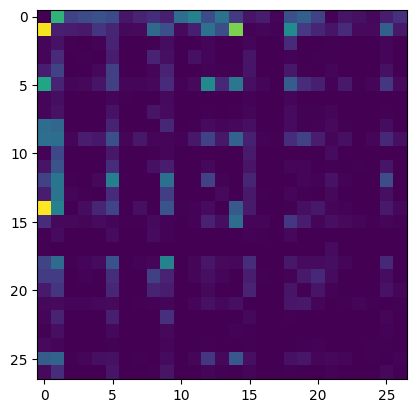

In [7]:
# display the matrix
plt.imshow(N)
plt.show()

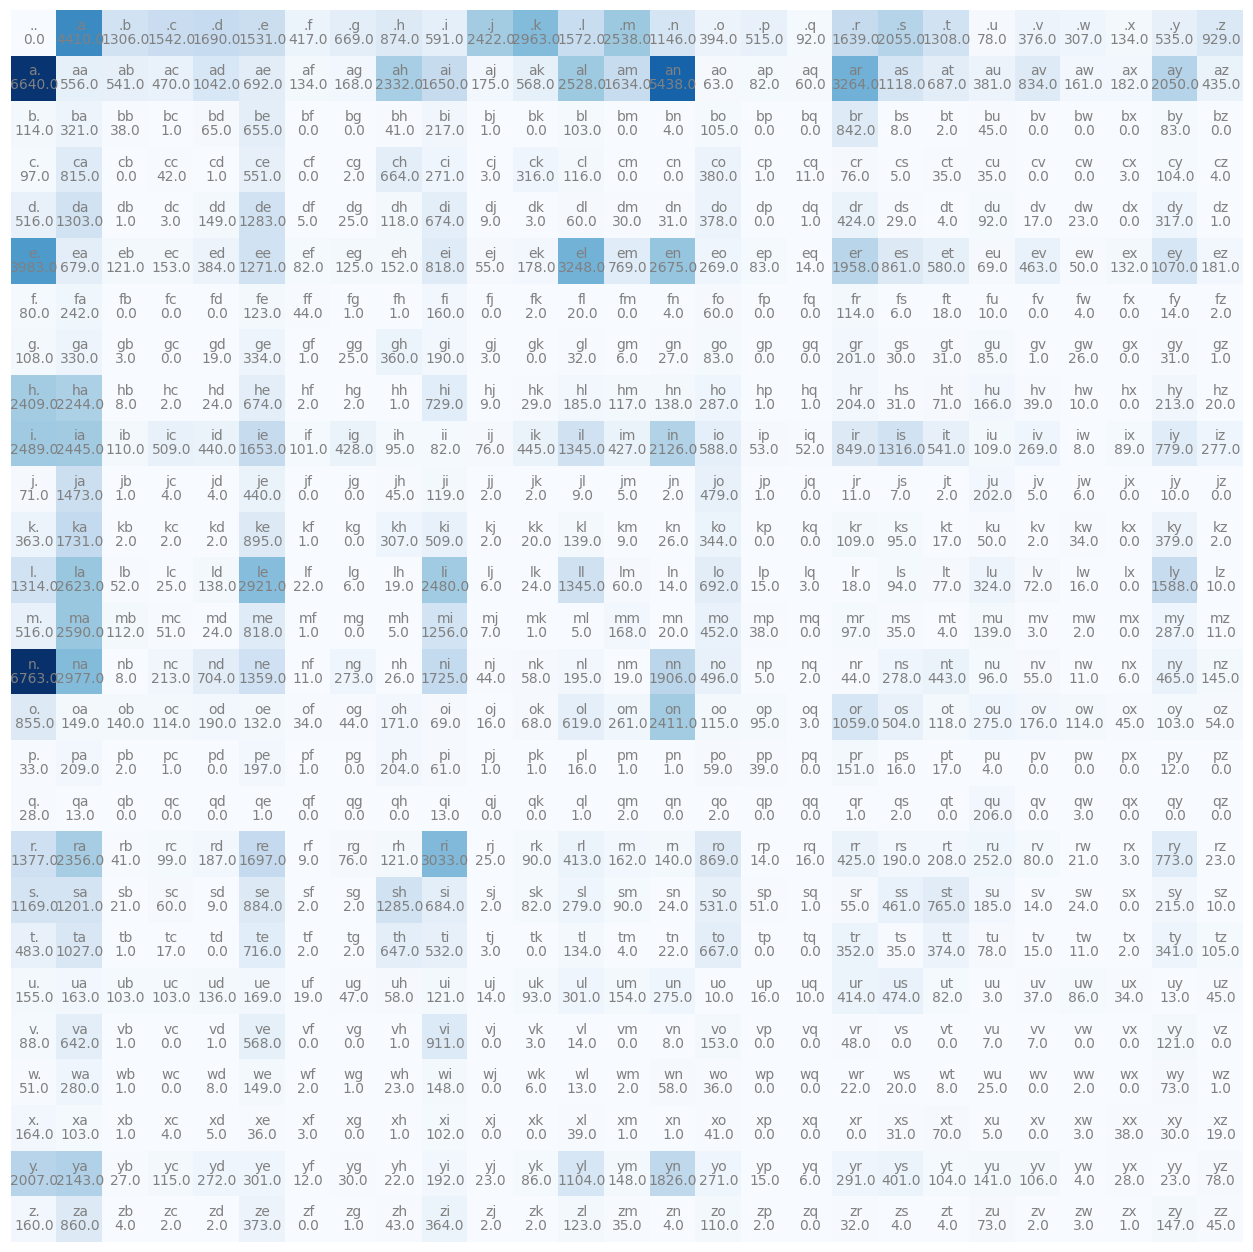

In [8]:
#display the matrix in human-readable format
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.show()

In [9]:
# useful to reproduce results
g = torch.Generator().manual_seed(2147483647)

In [10]:
sums = torch.sum(N, dim=1, keepdim=True)
P = N / sums

In [11]:
# sample 30 words from the model (hint: use torch.multinomial)
for _ in range(30):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, 1).item()
        if ix == 0:
            break
        else:
            out.append(itos[ix])
        
    print(''.join(out))

dler
miltriayl
jialela
ja
ardga
sakil
quz
aaniligety
apreereshaighann
a
zoliali
ckynatc
zania
ya
ah
aly
pisamongadendraih
sa
ayezaia
kisali
os
y
jarorva
ja
shi
kylaamina
sha
aviay
jondudeema
stanan


In [12]:
# Exercise 2: build the same bigram model using the NLL loss
# - the dataset is created and encoded for you
# - create the weights matrix W
# - build a training loop to minimize the NLL
# - sample from the model

In [13]:
# create a training set for bigram model
# (do not change this code) 
xs = []
ys = []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

In [14]:
import torch.nn.functional as F

In [15]:
print(xs.shape)
print(ys.shape)
print(len(set(''.join(words))))

torch.Size([228146])
torch.Size([228146])
26


In [16]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)
W.requires_grad=True

  0%|          | 0/50 [00:00<?, ?it/s]

Iter  0  : 3.758953809738159


 36%|███▌      | 18/50 [00:00<00:00, 37.69it/s]

Iter  10  : 2.6168413162231445


 52%|█████▏    | 26/50 [00:00<00:00, 34.84it/s]

Iter  20  : 2.5359978675842285


 72%|███████▏  | 36/50 [00:00<00:00, 40.66it/s]

Iter  30  : 2.53513765335083


100%|██████████| 50/50 [00:01<00:00, 39.98it/s]

Iter  40  : 2.50639009475708


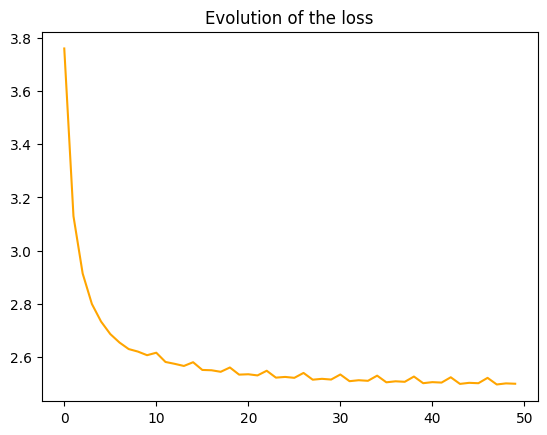

In [17]:
import math
from tqdm import tqdm 
losses = []
# training loop
for k in tqdm(range(50)):
    #forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # encode xs with F.one_hot
    #print("Shape of xenc :", xenc.shape)
    logits = xenc @ W 
    counts = logits.exp() 
    probs = counts / counts.sum(dim=1, keepdim=True)    
    loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() 

    # backward pass
    W.grad = None
    W.bias = None
    loss.backward()

    # update
    W.data -= 100 * W.grad
    losses.append(loss.item())
    if k % 10 == 0:
        print("Iter ", k, " :", loss.item())
plt.plot(range(50), losses, color="orange")
plt.title("Evolution of the loss")
plt.show()

In [18]:
# finally, sample from the neural net model
g = torch.Generator().manual_seed(2147483647)

for k in range(10):
    out = []
    ix = 0
    for _ in range(10):
        x = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = x @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True) 
        ix = torch.multinomial(probs, 1, generator=g).item() 
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out))

cexze
momanurail
azityharel
jimittain
llayn
kanar
staiyauela
berigotai
moliellavo
jan


In [19]:
# Exercise 3: homework (*) extend the previous model to trigram

In [20]:
# Exercise 4: let's build a better model
# Bengio et al. 2003 MLP language model paper, https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

On s'approprie les notations du papier: 

Nous avons une séquence d'entraînement $w_1, ..., w_T \in \text{words}$ où $\text{words} = V $. Attention, ici on prend les caractères (pas les prénoms !!)

Construisons le training et testing set: 

In [197]:
# build the dataset (do not change this code)
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size  # [0, 0, 0]
        for ch in w + '.':
            ix = stoi[ch]  # caractère à prédire 
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # update du context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

- Premièrement, on veut "mapper" chaque élément de $\text{words}$ en un vecteur de dimension $m$ choisie. On prend m = 10.

In [208]:
emb_size = 100

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)  #représente les vecteurs de caractéristiques distribués associés à chaque lettre 
W1 = torch.randn((30, emb_size), generator=g)
b1 = torch.randn(emb_size, generator=g)
W2 = torch.randn((emb_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True


In [209]:
# init weights (use torch.nn.init)
import torch.nn.init as init

b1 = init.zeros_(b1)
b2 = init.zeros_(b2)
W1 = init.uniform_(W1)
W2 = init.uniform_(W2)

stepi = []
lossi = []

for p in parameters:
    p.requires_grad = True

In [210]:
# training loop (use the cross-entropy loss)
batch_size = 500
nb_epochs = 10**4
lr = 5

for i in range(nb_epochs):
    
    # minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[ix] 
    Y_batch = Y_train[ix]

    # forward pass
    emb = C[X_batch].view(-1, 30)  # dimension (batch_size, 30 = 3 x 10) ; couche d'embedding
    h = torch.tanh(emb @ W1 + b1)  # couche cachée, transformation non linéaire 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr /= (1 + 0.000001 * i)
    for p in parameters:
        p.data -= lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    print(i, loss)

0 tensor(6.0136, grad_fn=<NllLossBackward0>)
1 tensor(30.8313, grad_fn=<NllLossBackward0>)
2 tensor(129.2970, grad_fn=<NllLossBackward0>)
3 tensor(162.3667, grad_fn=<NllLossBackward0>)
4 tensor(96.6745, grad_fn=<NllLossBackward0>)
5 tensor(75.2149, grad_fn=<NllLossBackward0>)
6 tensor(107.8828, grad_fn=<NllLossBackward0>)
7 tensor(95.0650, grad_fn=<NllLossBackward0>)
8 tensor(85.3733, grad_fn=<NllLossBackward0>)
9 tensor(62.7104, grad_fn=<NllLossBackward0>)
10 tensor(77.7880, grad_fn=<NllLossBackward0>)
11 tensor(90.4666, grad_fn=<NllLossBackward0>)
12 tensor(76.9824, grad_fn=<NllLossBackward0>)
13 tensor(78.2233, grad_fn=<NllLossBackward0>)
14 tensor(86.4700, grad_fn=<NllLossBackward0>)
15 tensor(97.3055, grad_fn=<NllLossBackward0>)
16 tensor(73.0332, grad_fn=<NllLossBackward0>)
17 tensor(54.9261, grad_fn=<NllLossBackward0>)
18 tensor(72.6411, grad_fn=<NllLossBackward0>)
19 tensor(73.9760, grad_fn=<NllLossBackward0>)
20 tensor(63.4534, grad_fn=<NllLossBackward0>)
21 tensor(53.8436, gr

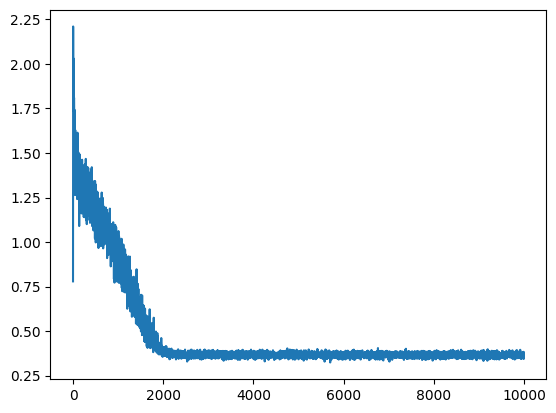

In [211]:
plt.plot(stepi, lossi)
plt.show()

In [212]:
# compute the train and val loss
def compute_loss(x, y):
    emb = C[x].view(-1, 30)  
    h = torch.tanh(emb @ W1 + b1)  
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y).item()
    print("La loss vaut: ", loss)
    return loss

print("Loss du Train set: ")
train_loss = compute_loss(X_train, Y_train)

print("Loss du Val set: ")
train_loss = compute_loss(X_dev, Y_dev)

Loss du Train set: 
La loss vaut:  2.325227975845337
Loss du Val set: 
La loss vaut:  2.3331875801086426


In [ ]:
# compute the train and val loss.  here are the initial results I got.  
# Improve the loss by playing with the hyper-params and learning rate policy and report the results here.

# batch_size = 500 ; lr = 0.05 ; emb_size = 100 ; nb_iter = 10**4
# Loss_train = 3.16 & Loss_val = 3.17

# batch_size = 248 ; lr = 10 w/ decay_rate ; emb_size = 100 ; nb_iter = 10**4
# Loss_train = 2.27 & Loss_val = 2.27

# batch_size = 500 ; lr = 10 w/ decay_rate ; emb_size = 100 ; nb_iter = 10**4
# Loss_train = 2.31 & Loss_val = 2.33

# batch_size = 248 ; lr = 10 w/ decay_rate ; emb_size = 150 ; nb_iter = 10**4
# Loss_train = 2.33 & Loss_val = 2.34

In [213]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 4)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

gari.
pyric.
tannalin.
ash.
leraalla.
jyle.
alisa.
barian.
kaisy.
krays.
een.
ains.
maliee.
dabaet.
elsalizil.
nori.
alatlea.
aniah.
anelar.
aaa.
